In [20]:
import pandas as pd

df = pd.read_csv('./data/train_df.csv', index_col=0)

train_data = df.loc[:'2018-01-01']
backtest_data = df.loc['2018-01-02':]

,time,code,open,close,high,low,volume,money
0,2014-01-02,510300.XSHG,2.402,2.401,2.408,2.389,185205422.0,4.441096e+08
1,2014-01-03,510300.XSHG,2.391,2.375,2.393,2.358,434406281.0,1.030051e+09
2,2014-01-06,510300.XSHG,2.367,2.318,2.367,2.312,476781679.0,1.106969e+09
3,2014-01-07,510300.XSHG,2.302,2.319,2.327,2.296,150496913.0,3.482149e+08
4,2014-01-08,510300.XSHG,2.319,2.317,2.341,2.304,202243149.0,4.696523e+08
...,...,...,...,...,...,...,...,...
1577,2020-06-23,510300.XSHG,4.639,4.671,4.676,4.623,351908413.0,1.638146e+09
1578,2020-06-24,510300.XSHG,4.682,4.711,4.715,4.680,404738154.0,1.899221e+09
1579,2020-06-29,510300.XSHG,4.696,4.671,4.707,4.646,187948562.0,8.768637e+08
1580,2020-06-30,510300.XSHG,4.693,4.727,4.743,4.691,479444125.0,2.264019e+09


In [21]:
import talib as ta


def get_features(data):
    tech_data = data.loc[:, ['close', 'time']]
    days = [2, 3, 4, 5]
    
    def get_target_level(increase):
        if increase > 0:
            return 1
        return 0
    
    for i in days:
        tech_data[f'factor_MOM_{i}'] = ta.MOM(tech_data.close, i)
        tech_data[f'factor_RSI_{i}'] = ta.RSI(tech_data.close, i)
        tech_data[f'factor_NATR_{i}'] = ta.NATR(data.high, data.low, data.close, timeperiod=i)
    
    tech_data['factor_OBV'] = ta.OBV(data.close, data.volume)
    tech_data['factor_OBV'] = tech_data['factor_OBV'].pct_change()
    
    tech_data['target'] = tech_data.close.pct_change().shift(-1).apply(get_target_level)
    tech_data = tech_data.set_index('time')
    
    features = [c for c in  tech_data.columns if c.startswith('factor')] 
    return tech_data.dropna(), features


data_sets, features= get_features(train_data)
print('训练数据:')
display(data_sets.head(5))
print('指标:', features)

0       2.401
1       2.375
2       2.318
3       2.319
4       2.317
        ...  
1577    4.671
1578    4.711
1579    4.671
1580    4.727
1581    4.834
Name: close, Length: 1582, dtype: float64
训练数据:


,close,factor_MOM_2,factor_RSI_2,factor_NATR_2,factor_MOM_3,factor_RSI_3,factor_NATR_3,factor_MOM_4,factor_RSI_4,factor_NATR_4,factor_MOM_5,factor_RSI_5,factor_NATR_5,factor_OBV,target
time,,,,,,,,,,,,,,,
2014-01-09,2.303,-0.016,0.975610,1.660877,-0.015,0.843882,1.773854,-0.072,0.955414,1.818281,-0.098,1.000000,1.832393,0.427536,0
2014-01-10,2.286,-0.031,0.419287,1.383421,-0.033,0.568586,1.555901,-0.032,0.741351,1.647255,-0.089,0.824742,1.695538,0.328852,0
2014-01-13,2.270,-0.033,0.202224,1.555617,-0.047,0.389294,1.617266,-0.049,0.578654,1.673665,-0.048,0.683761,1.709604,0.326559,1
2014-01-14,2.285,-0.001,49.358645,1.560449,-0.018,30.990308,1.596264,-0.032,21.981164,1.640881,-0.034,17.258567,1.673803,-0.126454,0
2014-01-15,2.285,0.015,49.358645,1.261625,-0.001,30.990308,1.385109,-0.018,21.981164,1.471361,-0.032,17.258567,1.531603,0.000000,1


指标: ['factor_MOM_2', 'factor_RSI_2', 'factor_NATR_2', 'factor_MOM_3', 'factor_RSI_3', 'factor_NATR_3', 'factor_MOM_4', 'factor_RSI_4', 'factor_NATR_4', 'factor_MOM_5', 'factor_RSI_5', 'factor_NATR_5', 'factor_OBV']


In [157]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LassoCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


X = data_sets[features]
y = data_sets['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print('训练label:', X_train.head(5))
print('训练target:', y_train.head(5))

训练label:             factor_MOM_2  factor_RSI_2  factor_NATR_2  factor_MOM_3  \
time                                                                  
2014-08-06        -0.023     40.697674       1.578830         0.030   
2018-02-09        -0.238      0.395752       4.704386        -0.345   
2016-04-27         0.003     34.394156       1.225367        -0.008   
2018-03-14        -0.063     21.677987       0.873462        -0.050   
2016-10-27        -0.016     33.589858       0.620338        -0.026   

            factor_RSI_3  factor_NATR_3  factor_MOM_4  factor_RSI_4  \
time                                                                  
2014-08-06     54.799362       1.609839         0.000     61.707776   
2018-02-09      1.730421       4.015964        -0.476      3.535859   
2016-04-27     35.230938       1.417163         0.007     35.279533   
2018-03-14     36.591169       1.007109        -0.018     43.464602   
2016-10-27     50.464647       0.710743         0.018     56.811140

In [26]:
svm_parameters = {
    'classification__n_estimators':(115, 120, 140, 160)
}
pipline = Pipeline([    
    ('preprocessing', StandardScaler()),
#     ('feature_selection', SelectFromModel(LogisticRegression())),
    ('classification', AdaBoostClassifier(base_estimator=SVC(kernel='linear'), algorithm='SAMME'))
])

svm = GridSearchCV(pipline, svm_parameters, cv=5)


svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
print('参数:', svm.best_params_)
print('准确率:', accuracy_score(y_test, svm_pred))
print('分类报告:', classification_report(y_test, svm_pred))

参数: {'classification__n_estimators': 115}
准确率: 0.525911708253359
分类报告:               precision    recall  f1-score   support

           0       0.49      0.55      0.52       244
           1       0.56      0.50      0.53       277

    accuracy                           0.53       521
   macro avg       0.53      0.53      0.53       521
weighted avg       0.53      0.53      0.53       521



In [179]:
rdf_parameters = {
    'classification__n_estimators':(140, 160, 170, 180), 
    'classification__max_depth':[4, 6, 7, 8, 9]
}

pipline = Pipeline([    
    ('preprocessing', StandardScaler()),
    ('feature_selection', SelectFromModel(LogisticRegression())),
    ('classification', RandomForestClassifier(random_state=44))
])

rdf = GridSearchCV(pipline, rdf_parameters, cv=5)


rdf.fit(X_train, y_train)
rdf_pred = rdf.predict(X_test)
print('参数:', rdf.best_params_)
print('准确率:', accuracy_score(y_test, rdf_pred))
print('分类报告:', classification_report(y_test, rdf_pred))

参数: {'classification__max_depth': 4, 'classification__n_estimators': 170}
准确率: 0.45297504798464494
分类报告:               precision    recall  f1-score   support

           0       0.43      0.30      0.35       259
           1       0.47      0.61      0.53       262

    accuracy                           0.45       521
   macro avg       0.45      0.45      0.44       521
weighted avg       0.45      0.45      0.44       521



In [236]:
import datetime
import backtrader as bt
import backtrader.feeds as btfeed

class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.today = self.data0.datetime.date
        pred_data, factors = get_features(df.loc[df.time >= '2018-01-01'])
        signal = pd.DataFrame(index=pred_data.index)
        signal.loc[:, 'is_buy'] = rdf.predict(pred_data[factors])
        self.signal = signal
        
        
    def next(self):
        today = self.datas[0].datetime.date(0).isoformat()
        today_signal = self.signal.loc[today, 'is_buy']
        if today_signal == 1:
            print('Buy!')
            self.order_target_percent(target=1)
        else:
            print('Sell!')
            self.close()


Starting Portfolio Value: 100000.00
Buy!
Buy!
Buy!
Buy!
Sell!
Sell!
Buy!
Buy!
Sell!
Sell!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Sell!
Sell!
Sell!
Sell!
Sell!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Sell!
Buy!
Buy!
Buy!
Sell!
Buy!
Buy!
Sell!
Buy!
Buy!
Sell!
Sell!
Buy!
Buy!
Buy!
Buy!
Buy!
Sell!
Sell!
Sell!
Sell!
Buy!
Buy!
Buy!
Buy!
Sell!
Buy!
Buy!
Sell!
Buy!
Sell!
Buy!
Buy!
Sell!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Sell!
Buy!
Buy!
Buy!
Buy!
Sell!
Buy!
Buy!
Buy!
Sell!
Sell!
Buy!
Buy!
Sell!
Buy!
Buy!
Buy!
Sell!
Sell!
Sell!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Sell!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Sell!
Sell!
Sell!
Buy!
Buy!
Buy!
Buy!
Buy!
Sell!
Buy!
Sell!
Sell!
Buy!
Sell!
Sell!
Buy!
Buy!
Buy!
Buy!
Buy!
Sell!
Buy!
Buy!
Buy!
Sell!
Sell!
Sell!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!
Sell!
Sell!
Buy!
Sell!
Buy!
Sell!
Buy!
Sell!
Buy!
Buy!
Buy!
Buy!
Sell!
Buy!
Buy!
Sell!
Buy!
Sell!
Sell!
Sell!
Sell!
Sell!
Sell!
Buy!
Sell!
Sell!
Sell!
Sell!

<IPython.core.display.Javascript object>


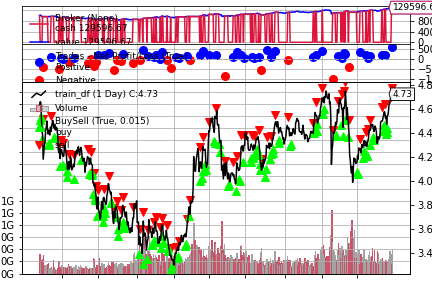

[[<Figure size 432x288 with 4 Axes>]]

In [237]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)


# Create a Data Feed
data = bt.feeds.GenericCSVData(
        dataname='data/train_df.csv',
        dtformat='%Y-%m-%d',
        fromdate=datetime.datetime(2018, 2, 1),
        todate=datetime.datetime(2020, 7, 1),
        datetime=1,
        high=5,
        low=6,
        open=3,
        close=4,
        volume=7,
        reverse=True)

cerebro.adddata(data)


cerebro.broker.setcash(100000.0)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot()

In [188]:
%matplotlib notebook